<div align='center'>

# VCF File Analysis
</div>
This notebook presents an analysis of a VCF file generated after haplotyping 16 yeast clones, containing combined SNV and indel variant calls. We explore annotated variants, identify mutagenesis hotspots, and detect strand-oriented mutation clusters — potentially driven by AID/APOBEC activity — across the yeast genomes to uncover patterns of AID/APOBEC mutagenic activity. 





In [ ]:
import io
import os
from collections import defaultdict
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter
from scipy.cluster.hierarchy import linkage, fcluster

In [20]:
chromosome_map = {
    "NC_001133.9": "chI",
    "NC_001134.8": "chII",
    "NC_001135.5": "chIII",
    "NC_001136.10": "chIV",
    "NC_001137.3": "chV",
    "NC_001138.5": "chVI",
    "NC_001139.9": "chVII",
    "NC_001140.6": "chVIII",
    "NC_001141.2": "chIX",
    "NC_001142.9": "chX",
    "NC_001143.9": "chXI",
    "NC_001144.5": "chXII",
    "NC_001145.3": "chXIII",
    "NC_001146.8": "chXIV",
    "NC_001147.6": "chXV",
    "NC_001148.4": "chXVI",
    "NC_001224.1": "MT",
}

yeast_chromosomes = {
    "chI": 230,
    "chII": 813,
    "chIII": 316,
    "chIV": 1532,
    "chV": 577,
    "chVI": 270,
    "chVII": 1091,
    "chVIII": 563,
    "chIX": 440,
    "chX": 745,
    "chXI": 666,
    "chXII": 1078,
    "chXIII": 924,
    "chXIV": 784,
    "chXV": 1091,
    "chXVI": 948,
}

## 1. VCF file loading and preprocessing

In [21]:
vcf_path = "all_snvs_nogt.vcf"
with open(vcf_path) as f:
    lines = [line for line in f if not line.startswith("##")]

vcf_df = pd.read_csv(io.StringIO("".join(lines)), sep="\t")

vcf_df["#CHROM"] = vcf_df["#CHROM"].map(chromosome_map).fillna(vcf_df["#CHROM"])

In [22]:
telomere_regions = {}
centromere_regions = {}

for line in open("telomeres.bed"):
    chrom, start, end = line.strip().split("\t")
    telomere_regions.setdefault(chrom, []).append((int(start), int(end)))

for line in open("centromeres.bed"):
    chrom, start, end = line.strip().split("\t")
    centromere_regions.setdefault(chrom, []).append((int(start), int(end)))

telomere_regions = {chromosome_map.get(k, k): v for k, v in telomere_regions.items()}
centromere_regions = {
    chromosome_map.get(k, k): v for k, v in centromere_regions.items()
}

In [23]:
with open("unique_to_hst.sorted.vcf") as f:
    vcf_sep_df = pd.read_csv(
        io.StringIO("".join(line for line in f if not line.startswith("##"))), sep="\t"
    )

vcf_sep_df["#CHROM"] = (
    vcf_sep_df["#CHROM"].map(chromosome_map).fillna(vcf_sep_df["#CHROM"])
)
vcf_sep_df = vcf_sep_df[
    vcf_sep_df["#CHROM"].isin(
        {"chI", "chIII", "chIV", "chV", "chVI", "chVII", "chVIII", "chX", "chXIV"}
    )
]

os.makedirs("clone_tables", exist_ok=True)
for clone in [col for col in vcf_sep_df.columns if col.startswith("hst")]:
    mask = vcf_sep_df[clone].apply(
        lambda gt: False if pd.isna(gt) else gt.split(":")[0] == "1"
    )
    if any(mask):
        vcf_sep_df[mask].to_csv(f"clone_tables/{clone}_with_mutations.csv", index=False)

## 2. SNV Annotation Profiling

In [24]:
def parse_consequence(info_str):
    for entry in info_str.split(";"):
        if entry.startswith("CSQ="):
            return [e.split("|")[1] for e in entry[4:].split(",")]
    return []


def categorize(consequence):
    if (
        "missense" in consequence
        or "synonymous" in consequence
        or "stop_gained" in consequence
    ):
        return "ORF"
    elif "UTR" in consequence:
        return "UTR"
    elif any(x in consequence for x in ["upstream", "downstream", "intergenic"]):
        return "Intergenic"
    return "Other"


vcf_df["Consequence"] = vcf_df["INFO"].apply(parse_consequence)
vcf = vcf_df.explode("Consequence")
vcf["Category"] = vcf["Consequence"].apply(categorize)

summary_all = vcf["Category"].value_counts().to_frame("Count")
summary_all["Percentage"] = summary_all["Count"] / summary_all["Count"].sum() * 100
summary_all

,Count,Percentage
Category,,
Intergenic,2597,87.352842
ORF,372,12.512614
Other,4,0.134544


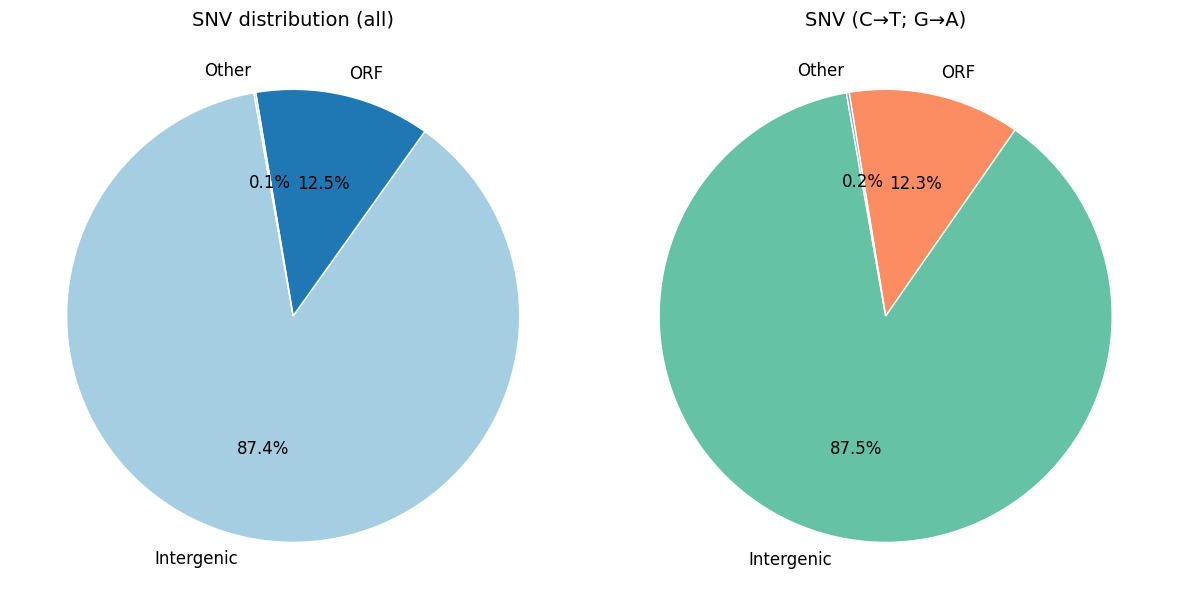

In [25]:
vcf_snv = vcf_df[
    ((vcf_df["REF"] == "C") & (vcf_df["ALT"] == "T"))
    | ((vcf_df["REF"] == "G") & (vcf_df["ALT"] == "A"))
].copy()

vcf_snv["Consequence"] = vcf_snv["INFO"].apply(parse_consequence)
vcf_snv = vcf_snv.explode("Consequence")
vcf_snv["Category"] = vcf_snv["Consequence"].apply(categorize)

summary_snv = vcf_snv["Category"].value_counts().to_frame("Count")
summary_snv["Percentage"] = summary_snv["Count"] / summary_snv["Count"].sum() * 100

colors_all = plt.cm.Paired.colors[: len(summary_all)]
colors_snv = plt.cm.Set2.colors[: len(summary_snv)]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].pie(
    summary_all["Count"],
    labels=summary_all.index,
    autopct="%1.1f%%",
    startangle=100,
    colors=colors_all,
    wedgeprops={"edgecolor": "white"},
    textprops={"fontsize": 12},
)
axes[0].set_title("SNV distribution (all)", fontsize=14)

axes[1].pie(
    summary_snv["Count"],
    labels=summary_snv.index,
    autopct="%1.1f%%",
    startangle=100,
    colors=colors_snv,
    wedgeprops={"edgecolor": "white"},
    textprops={"fontsize": 12},
)
axes[1].set_title("SNV (C→T; G→A)", fontsize=14)

plt.tight_layout()
plt.show()

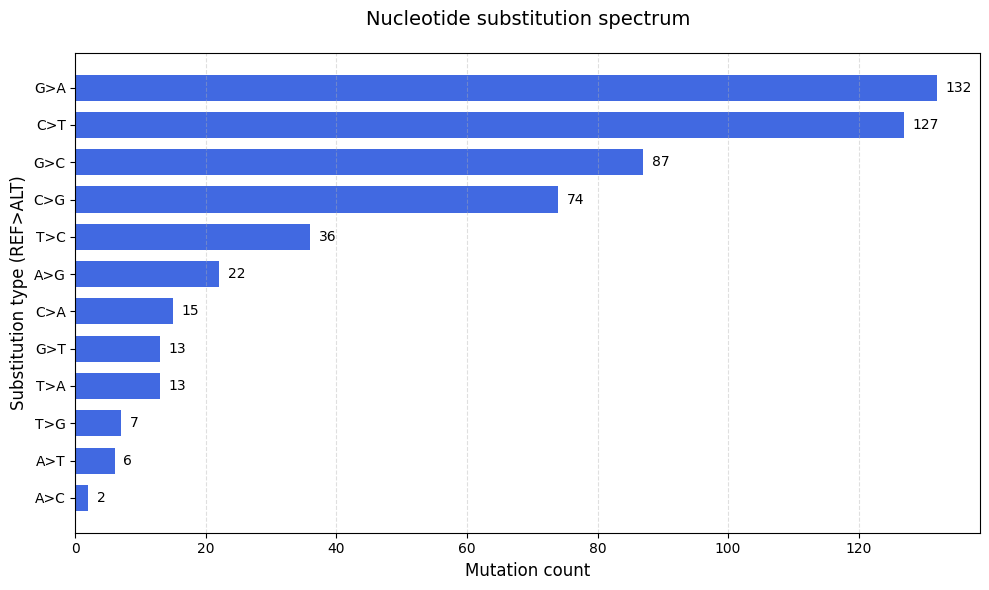

In [26]:
vcf_df["mutation_type"] = vcf_df["REF"] + ">" + vcf_df["ALT"]
mutation_counts = vcf_df["mutation_type"].value_counts().sort_values(ascending=True)

plt.figure(figsize=(10, 6))
bars = plt.barh(
    mutation_counts.index, mutation_counts.values, color="royalblue", height=0.7
)
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + max(mutation_counts) * 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{width:,}",
        va="center",
    )

plt.xlabel("Mutation count", fontsize=12)
plt.ylabel("Substitution type (REF>ALT)", fontsize=12)
plt.title("Nucleotide substitution spectrum", fontsize=14, pad=20)
plt.grid(axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

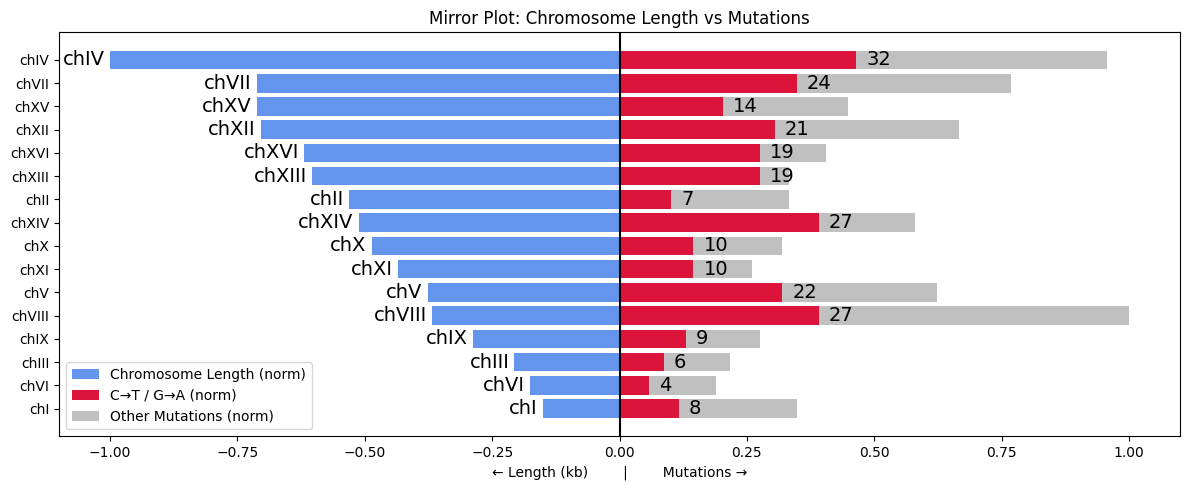

In [27]:
vcf_df["is_ct_ga"] = vcf_df.apply(
    lambda row: (row["REF"] == "C" and row["ALT"] == "T")
    or (row["REF"] == "G" and row["ALT"] == "A"),
    axis=1,
)

mutation_counts = (
    vcf_df["#CHROM"].value_counts().rename_axis("chrom").reset_index(name="total")
)
ctga_counts = (
    vcf_df[vcf_df["is_ct_ga"]]["#CHROM"]
    .value_counts()
    .rename_axis("chrom")
    .reset_index(name="ct_ga")
)

merged = pd.merge(mutation_counts, ctga_counts, on="chrom", how="left").fillna(0)
merged["ct_ga"] = merged["ct_ga"].astype(int)
merged["non_ct_ga"] = merged["total"] - merged["ct_ga"]
merged["non_ct_ga"] = merged["non_ct_ga"].clip(lower=0)

merged["length"] = merged["chrom"].map(yeast_chromosomes)

merged = merged.dropna(subset=["length"])
merged = merged[merged["total"] > 0]

merged = merged.sort_values(by="length", ascending=False).reset_index(drop=True)

total_max = merged["total"].max()
merged["length_norm"] = merged["length"] / merged["length"].max()
merged["ct_ga_norm"] = merged["ct_ga"] / total_max
merged["non_ct_ga_norm"] = merged["non_ct_ga"] / total_max

y_pos = range(len(merged))

fig, ax = plt.subplots(figsize=(12, 5))

ax.barh(
    y=y_pos,
    width=-merged["length_norm"],
    color="#6495ED",
    align="center",
    label="Chromosome Length (norm)",
)
ax.barh(
    y=y_pos,
    width=merged["ct_ga_norm"],
    color="#DC143C",
    align="center",
    label="C→T / G→A (norm)",
)
ax.barh(
    y=y_pos,
    width=merged["non_ct_ga_norm"],
    left=merged["ct_ga_norm"],
    color="silver",
    align="center",
    label="Other Mutations (norm)",
)

for y, (_, row) in zip(y_pos, merged.iterrows()):
    ax.text(
        -row["length_norm"] - 0.01,
        y,
        row["chrom"],
        va="center",
        ha="right",
        fontsize=14,
        color="black",
    )
    ax.text(
        row["ct_ga_norm"] + 0.02,
        y,
        int(row["ct_ga"]),
        va="center",
        ha="left",
        fontsize=14,
        color="black",
    )

ax.set_yticks(y_pos)
ax.set_yticklabels(merged["chrom"])
ax.axvline(0, color="black")
ax.set_xlabel("← Length (kb)        |        Mutations →")
ax.set_title("Mirror Plot: Chromosome Length vs Mutations")
ax.legend(loc="best")
ax.invert_yaxis()

plt.tight_layout()
plt.show()

## 3. Clustering analysis

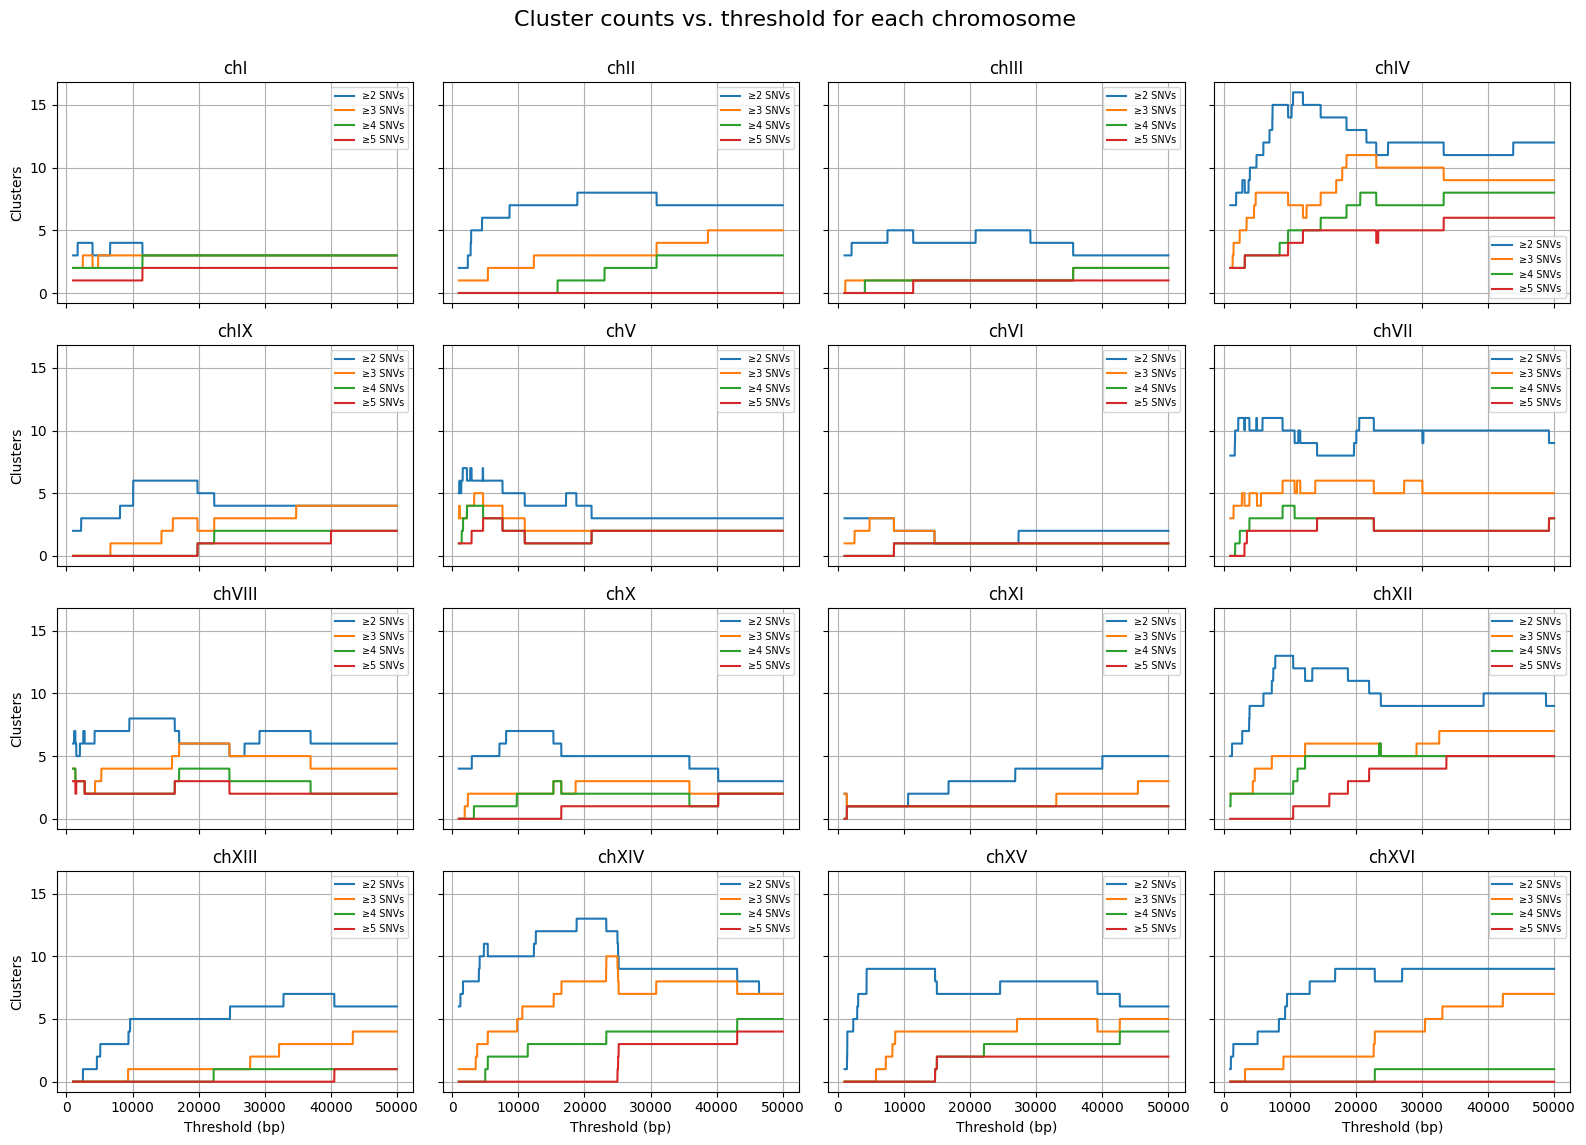

In [28]:
thresholds = range(1000, 50000, 10)
min_sizes = [2, 3, 4, 5]
results = defaultdict(lambda: defaultdict(list))

for chrom, group in vcf_df.groupby("#CHROM"):
    positions = group["POS"].to_numpy()
    if len(positions) < 2:
        continue

    X = positions.reshape(-1, 1)
    Z = linkage(X, method="average", metric="euclidean")

    for threshold in thresholds:
        cluster_labels = fcluster(Z, t=threshold, criterion="distance")
        clusters = defaultdict(list)
        for idx, label in enumerate(cluster_labels):
            clusters[label].append(positions[idx])

        for min_size in min_sizes:
            count = sum(1 for snvs in clusters.values() if len(snvs) >= min_size)
            results[chrom][min_size].append(count)

chroms = sorted(results.keys())
n_chroms = len(chroms)
ncols = 4
nrows = ceil(n_chroms / ncols)

fig, axes = plt.subplots(
    nrows, ncols, figsize=(ncols * 4, nrows * 3), sharex=True, sharey=True
)
axes = axes.flatten()

for idx, chrom in enumerate(chroms):
    ax = axes[idx]
    for min_size in min_sizes:
        label = f"≥{min_size} SNVs" if min_size > 1 else "All"
        ax.plot(thresholds, results[chrom][min_size], label=label)
    ax.set_title(str(chrom))
    ax.grid(True)
    if idx % ncols == 0:
        ax.set_ylabel("Clusters")
    if idx >= (nrows - 1) * ncols:
        ax.set_xlabel("Threshold (bp)")
    ax.legend(fontsize="x-small")

for ax in axes[len(chroms) :]:
    ax.axis("off")

fig.suptitle("Cluster counts vs. threshold for each chromosome", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

In [29]:
rainfall_clusters = {}

for chrom, group in vcf_df.groupby("#CHROM"):
    if group.empty:
        continue
    positions = group["POS"].to_numpy()
    if len(positions) < 2:
        continue

    X = positions.reshape(-1, 1)
    Z = linkage(X, method="average", metric="euclidean")

    threshold = 10000

    cluster_labels = fcluster(Z, t=threshold, criterion="distance")

    clusters = defaultdict(list)
    for idx, label in enumerate(cluster_labels):
        clusters[label].append(positions[idx])

    for cluster_id, snvs in sorted(clusters.items()):
        if len(snvs) >= 4:
            print(f"{chrom} - Cluster {cluster_id} ({len(snvs)} SNVs): {sorted(snvs)}")
            if chrom not in rainfall_clusters:
                rainfall_clusters[chrom] = []
            rainfall_clusters[chrom].extend(sorted(map(int, snvs)))

chI - Cluster 1 (4 SNVs): [np.int64(206351), np.int64(206360), np.int64(206363), np.int64(206462)]
chI - Cluster 2 (14 SNVs): [np.int64(16046), np.int64(18498), np.int64(18517), np.int64(20923), np.int64(21058), np.int64(21346), np.int64(21460), np.int64(21485), np.int64(21541), np.int64(21572), np.int64(21573), np.int64(22181), np.int64(22197), np.int64(22528)]
chIII - Cluster 3 (4 SNVs): [np.int64(281977), np.int64(281980), np.int64(283083), np.int64(286407)]
chIV - Cluster 1 (6 SNVs): [np.int64(179367), np.int64(179372), np.int64(183959), np.int64(188331), np.int64(190849), np.int64(192727)]
chIV - Cluster 7 (11 SNVs): [np.int64(527482), np.int64(527492), np.int64(527494), np.int64(527498), np.int64(527501), np.int64(527503), np.int64(527505), np.int64(527515), np.int64(527518), np.int64(527523), np.int64(527524)]
chIV - Cluster 20 (5 SNVs): [np.int64(821084), np.int64(822019), np.int64(823752), np.int64(824943), np.int64(825522)]
chIV - Cluster 22 (4 SNVs): [np.int64(846334), np.in

In [30]:
class RainfallPlotter:
    def __init__(self, vcf_df, rainfall_clusters, telomere_regions=None):
        self.vcf_df = vcf_df
        self.rainfall_clusters = rainfall_clusters
        self.telomere_regions = telomere_regions or {}
        self.mutation_colors = {"C>T": "#DC143C", "G>A": "#6495ED"}

    @staticmethod
    def human_format(x, pos):
        return f"{int(x):,}"

    @staticmethod
    def get_substitution(ref, alt):
        return f"{ref}>{alt}"

    def plot(self, chromosomes=None):
        if chromosomes is None:
            chromosomes = [
                chrom for chrom in self.vcf_df["#CHROM"].unique() if chrom != "MT"
            ]

        fig, axs = plt.subplots(
            len(chromosomes), 1, figsize=(10, 2 * len(chromosomes)), sharex=True
        )
        if len(chromosomes) == 1:
            axs = [axs]

        formatter = FuncFormatter(self.human_format)

        vcf_df_sorted = self.vcf_df.sort_values(["#CHROM", "POS"])
        cluster_positions = {
            (chrom, pos)
            for chrom, pos_list in self.rainfall_clusters.items()
            for pos in pos_list
        }

        for ax, chrom in zip(axs, chromosomes):
            chrom_df = vcf_df_sorted[vcf_df_sorted["#CHROM"] == chrom].reset_index(
                drop=True
            )
            positions = chrom_df["POS"].values
            refs = chrom_df["REF"].values
            alts = chrom_df["ALT"].values

            if len(positions) < 2:
                continue

            distances = np.diff(positions)
            log_distances = np.log2(distances)
            xs = positions[:-1]

            for i in range(len(xs)):
                pos = xs[i]
                sub = self.get_substitution(refs[i], alts[i])
                color = self.mutation_colors.get(sub, "gray")
                ax.scatter(pos, log_distances[i], s=20, color=color, alpha=1)

                if (chrom, pos) in cluster_positions:
                    ax.scatter(
                        pos,
                        log_distances[i],
                        s=100,
                        color=self.mutation_colors.get(sub, "lightslategray"),
                        alpha=0.2,
                    )

            for start, end in self.telomere_regions.get(chrom, []):
                ax.add_patch(
                    Rectangle(
                        (start, 0),
                        end - start,
                        ax.get_ylim()[1],
                        color="black",
                        alpha=0.5,
                        label="Telomere",
                    )
                )

            if chrom == "chV":
                ax.add_patch(
                    Rectangle(
                        (31694, 0),
                        33466 - 31694,
                        ax.get_ylim()[1],
                        color="gold",
                        alpha=0.6,
                        label="CAN1",
                    )
                )

            if chrom == "chVII":
                ax.add_patch(
                    Rectangle(
                        (255284, 0),
                        258280 - 255284,
                        ax.get_ylim()[1],
                        color="palegreen",
                        alpha=0.6,
                        label="Cluster",
                    )
                )

            ax.set_title(f"{chrom}", fontsize=12, weight="bold")
            ax.set_ylabel("Distance (log2)", fontsize=9)
            ax.grid(True, linestyle="--", alpha=0.5)
            ax.xaxis.set_major_formatter(formatter)
            fig.patch.set_alpha(0)
            ax.set_facecolor("aliceblue")

        axs[-1].set_xlabel("Genomic Position")
        plt.suptitle("Rainfall Plot with Mutation Clusters", fontsize=16, weight="bold")
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()

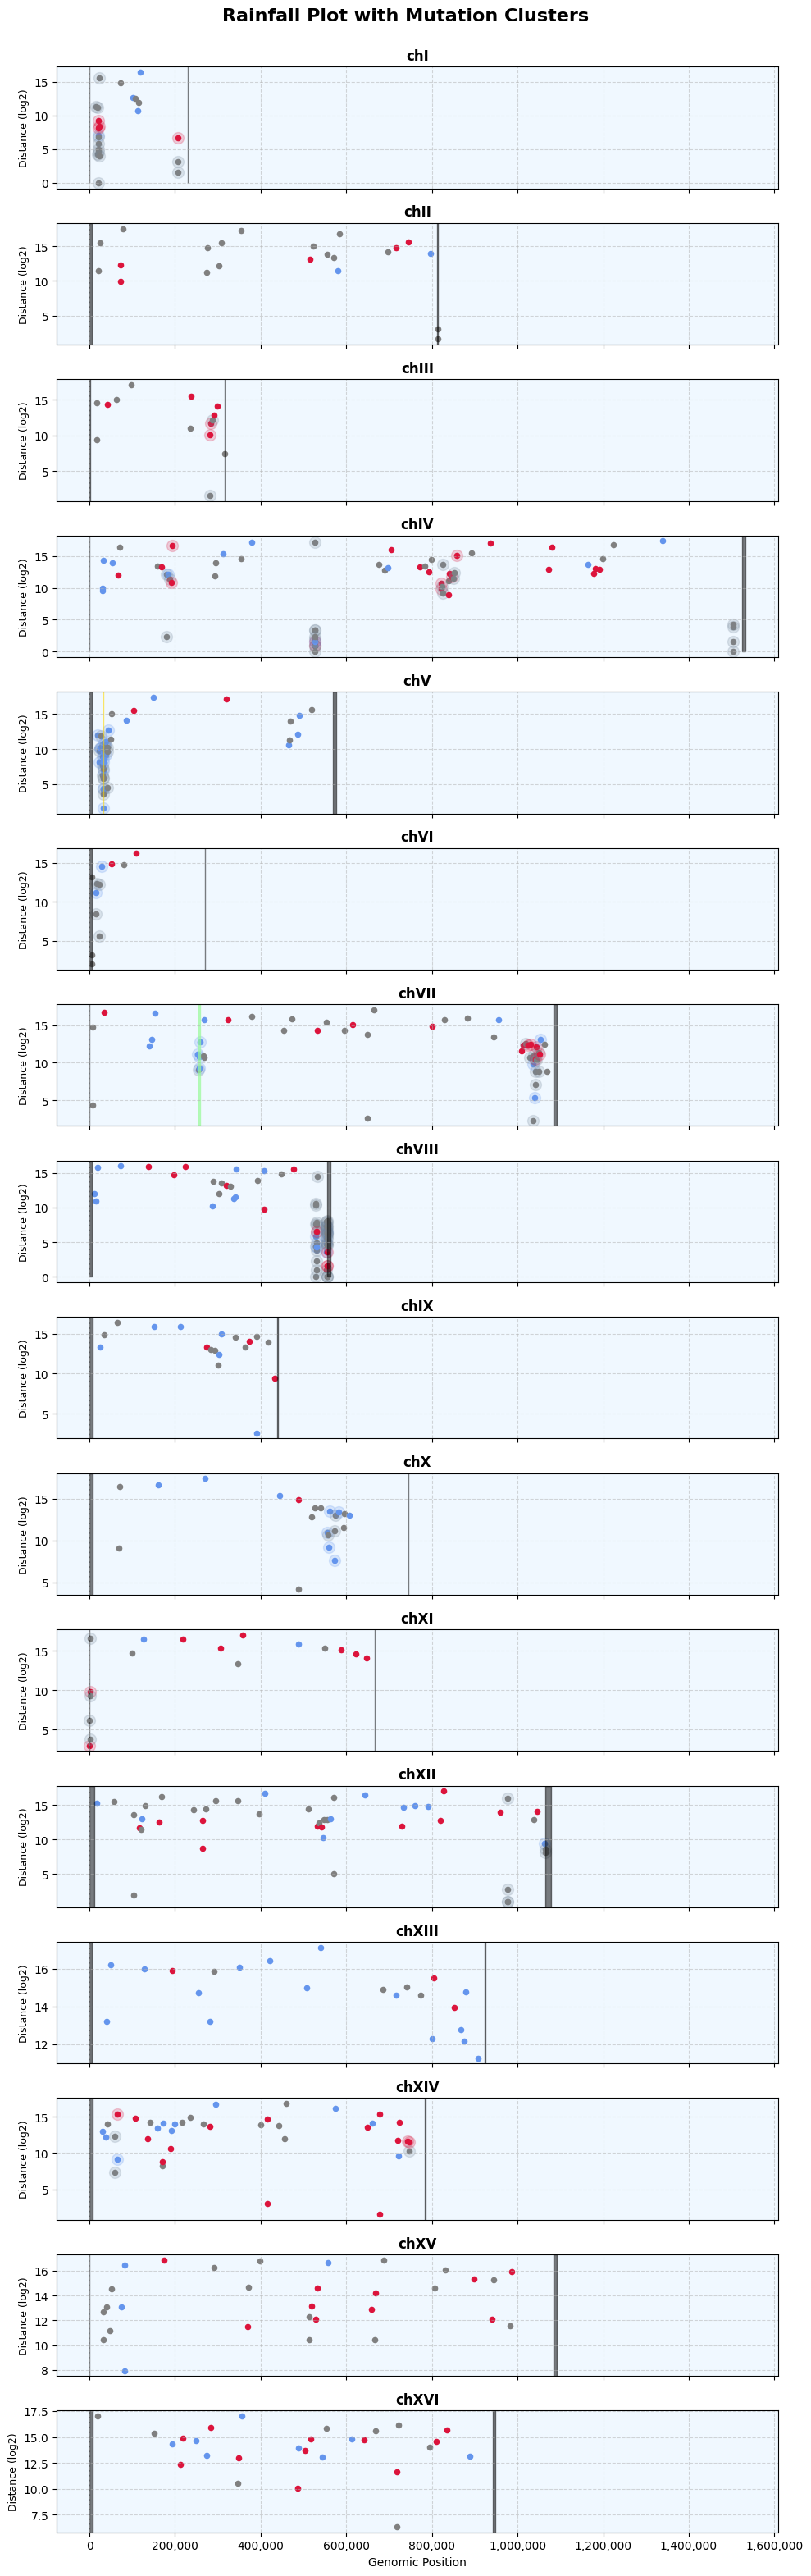

In [31]:
plotter = RainfallPlotter(vcf_df, rainfall_clusters, telomere_regions)
plotter.plot()

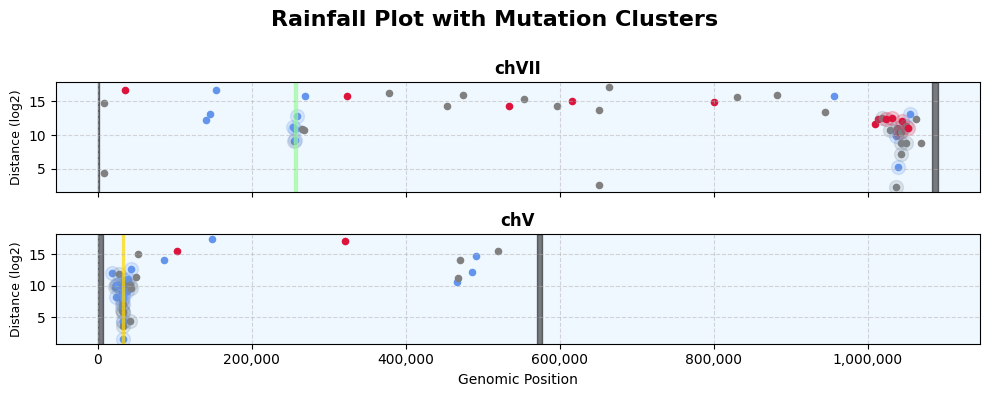

In [32]:
plotter = RainfallPlotter(vcf_df, rainfall_clusters, telomere_regions)
plotter.plot(chromosomes=["chVII", "chV"])

## 4. Strand-сoordinated mutation clustering

In [33]:
def is_transition(ref, alt):
    return (ref == "C" and alt == "T") or (ref == "G" and alt == "A")


true_clusters_per_clone = {}

for file in os.listdir("clone_tables"):
    if not file.endswith(".csv"):
        continue

    clone = file.replace("_with_mutations.csv", "")
    clone_df = pd.read_csv(os.path.join("clone_tables", file))

    rainfall_clusters = {}

    for chrom, group in clone_df.groupby("#CHROM"):
        positions = group["POS"].to_numpy()
        if len(positions) < 2:
            continue

        X = positions.reshape(-1, 1)
        Z = linkage(X, method="average", metric="euclidean")
        cluster_labels = fcluster(Z, t=10000, criterion="distance")

        clusters = defaultdict(list)
        for idx, label in enumerate(cluster_labels):
            clusters[label].append(positions[idx])

        for cluster_id, snvs in clusters.items():
            if len(snvs) >= 4:
                cluster_df = group[group["POS"].isin(snvs)]
                non_transition_count = 0
                for _, row in cluster_df.iterrows():
                    ref = row["REF"]
                    alt = row["ALT"]
                    if not is_transition(ref, alt):
                        non_transition_count += 1

                if non_transition_count <= len(snvs) * 0.5:
                    if chrom not in rainfall_clusters:
                        rainfall_clusters[chrom] = []
                    rainfall_clusters[chrom].extend(sorted(snvs))

    if rainfall_clusters:
        true_clusters_per_clone[clone] = rainfall_clusters

for clone, clusters in true_clusters_per_clone.items():
    print(f"\n=== {clone} ===")
    for chrom, positions in clusters.items():
        print(f"{chrom}: {len(positions)} clustered SNVs at positions: {positions}")


=== hst3.4.10 ===
chX: 4 clustered SNVs at positions: [np.int64(571748), np.int64(571951), np.int64(574217), np.int64(582407)]

=== hst3.4.14 ===
chVII: 4 clustered SNVs at positions: [np.int64(255284), np.int64(255822), np.int64(256446), np.int64(258280)]

=== hst3.4.3 ===
chV: 5 clustered SNVs at positions: [np.int64(22770), np.int64(23662), np.int64(25095), np.int64(26240), np.int64(32253)]

=== hst3.4.6 ===
chIV: 4 clustered SNVs at positions: [np.int64(846334), np.int64(849764), np.int64(852579), np.int64(858014)]
chXIV: 4 clustered SNVs at positions: [np.int64(743105), np.int64(746296), np.int64(746299), np.int64(747539)]


In [34]:
def visualize_clustered_variants_only(
    true_clusters_per_clone, base_path="clone_tables"
):
    for clone_name, rainfall_clusters in true_clusters_per_clone.items():
        print(f"Visualizing clusters for: {clone_name}")
        vcf_path = os.path.join(base_path, f"{clone_name}_with_mutations.csv")
        vcf_df = pd.read_csv(vcf_path)

        clustered_positions = set()
        for chrom, pos_list in rainfall_clusters.items():
            for pos in pos_list:
                clustered_positions.add((chrom, pos))

        filtered_vcf_df = vcf_df[
            vcf_df.apply(
                lambda row: (row["#CHROM"], row["POS"]) in clustered_positions, axis=1
            )
        ].copy()

        if not filtered_vcf_df.empty:
            plotter = RainfallPlotter(filtered_vcf_df, rainfall_clusters)
            plotter.plot()

Visualizing clusters for: hst3.4.10


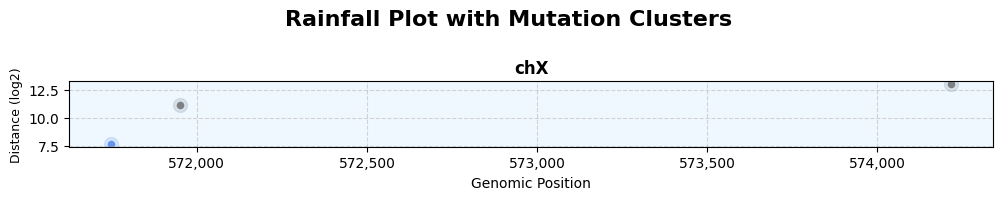

Visualizing clusters for: hst3.4.14


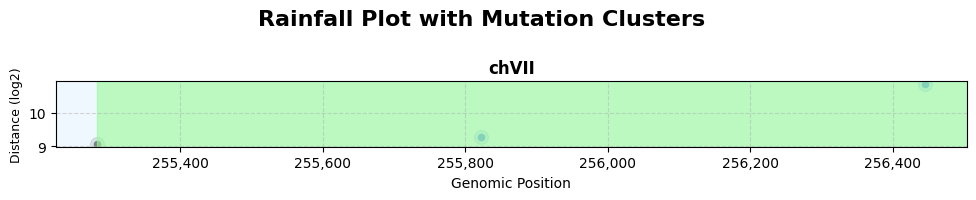

Visualizing clusters for: hst3.4.3


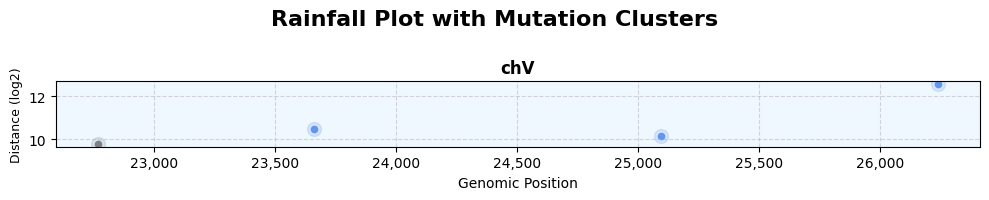

Visualizing clusters for: hst3.4.6


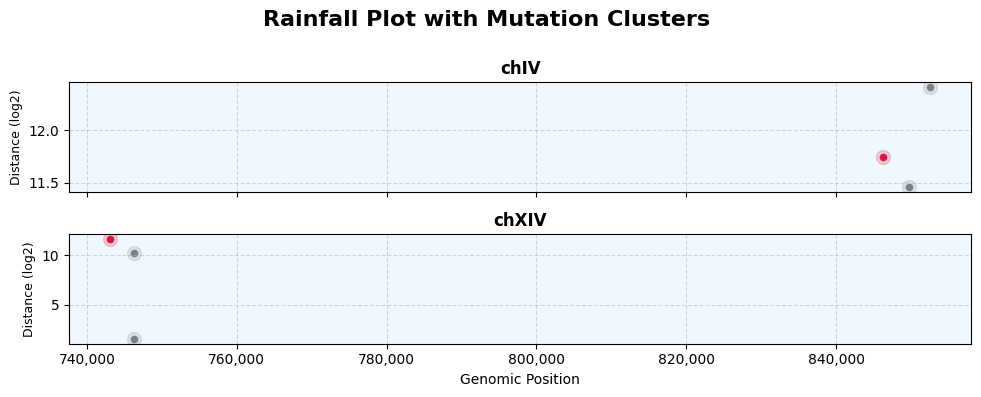

In [35]:
visualize_clustered_variants_only(true_clusters_per_clone)

## 5. Extract gene names with C->T G->C substitutions

In [36]:
def parse_consequence(info_str):
    for entry in info_str.split(";"):
        if entry.startswith("CSQ="):
            csq_data = entry[4:].split(",")
            return [
                e.split("|")[3]
                for e in csq_data
                if "missense" in e or "synonymous" in e or "stop_gained" in e
            ]
    return []


filtered_vcf = vcf[
    ((vcf["REF"] == "C") & (vcf["ALT"] == "T"))
    | ((vcf["REF"] == "G") & (vcf["ALT"] == "A"))
].copy()
filtered_vcf["genes"] = filtered_vcf["INFO"].apply(parse_consequence)
all_genes = [gene for gene_list in filtered_vcf["genes"] for gene in gene_list]
unique_genes = set(all_genes)
with open("unique_genes.txt", "w") as f:
    f.write(" ".join(unique_genes))